<h2><center>Starter Code for Semantic Segmentarion</center></h2>

![](https://images.aicrowd.com/raw_images/challenges/banner_file/900/829854c277eda136d9c9.jpg)

### What we are going to Learn

  - Using [segmentation_model.pytorch](https://github.com/qubvel/segmentation_models.pytorch) and **Unet** for **multi class** semantic segmentation

Note : Create a copy of the notebook and use the copy for submission. Go to File > Save a Copy in Drive to create a new copy



# Downloading Dataset

Installing `aicrowd-cli`

In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 209 kB 22.7 MB/s 
     |████████████████████████████████| 170 kB 36.9 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 62 kB 736 kB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/FiUKthnHkdZlWcxvziXZ2_i_MJUSqw4NJ5Z0Q5ifJGQ
API Key valid
Saved API Key successfully!


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c scene-segmentation -o data

test.zip:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [ ]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

# Downloading & Importing Libraries

Here we are going to use segmentation_models.pytorch which is a really popular library providing a tons of different segmentation models for pytorch including basic unets to DeepLabV3!

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-q2x0s5k1
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-q2x0s5k1
     |████████████████████████████████| 58 kB 4.9 MB/s 
     |████████████████████████████████| 376 kB 26.8 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88675 sha256=b39639f78c993111eff21035e659b7e50182047691a34f648890976fd6c7e915
  Stored in directory: /tmp/pip-ephem-wheel-cache-9m27z5ow/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=bc514801f4076eb4164b714de0a5b846d060489f6eb571086c7e139594f1f30b
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-n

In [ ]:
# Pytorch 
import torch
from torch import nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

# Reading Dataset, vis and miscellaneous
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
from natsort import natsorted
from tqdm.notebook import tqdm
import cv2

# Creating the Dataloader

In this section, we will be creating the dataloader that our model will use for the loading batches of corrosponding features and labels for training & testing

In [ ]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, img_directory=None, label_directory=None, train=True):
        

        self.img_directory = img_directory
        self.label_directory = label_directory            

        # If the image direcotry is valid ( using only 500 images for faster training )
        if img_directory != None:

          if train:
            self.img_list = natsorted(os.listdir(img_directory))[:500]
          else:
            self.img_list = natsorted(os.listdir(img_directory))

        if train:
          self.label_list = natsorted(os.listdir(label_directory))[:500]

        self.train = train

        self.labels = list(range(0, 25))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        # Reading the image
        img = Image.open(os.path.join(self.img_directory, self.img_list[idx]))
        img = img.convert("L")

        if self.train == True:
          
          # Readiding the mak image
          mask = Image.open(os.path.join(self.label_directory, self.label_list[idx]))

          # mask.show()
          img = np.array(img, dtype=np.float32)
          mask = np.array(mask, dtype=np.float32)

          # Change image channel ordering
          img = img[np.newaxis, :, :]


          # Normalizing images
          img = torch.from_numpy(img)
          img = img.float()/255

          binary_mask = np.array([(mask == v) for v in list(self.labels)])
          binary_mask = np.stack(binary_mask, axis=-1).astype('float')

          mask_preprocessed = binary_mask.transpose(2, 0, 1)
          mask_preprocessed = torch.from_numpy(mask_preprocessed)

          return img, mask_preprocessed
        
        # If reading test dataset, only return image 
        else:
          
          img = np.array(img, dtype=np.float32)
          img = img[np.newaxis, :, :]
          # img = np.moveaxis(img, -1, 0)

          # Normalizing images
          img = torch.from_numpy(img)
          img = img.float()/255
          

          return img

In [ ]:
# Creating the training dataset
train_dataset = SemanticSegmentationDataset(img_directory="./data/train/image", label_directory="./data/train/segmentation")
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=0, shuffle=False, drop_last=True)

In [ ]:
# Reading the image and corrosponding segmentation
image_batch, segmentation_batch = next(iter(train_loader))

image_batch.shape, segmentation_batch.shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 25, 512, 512]))

# Visualizing Dataset

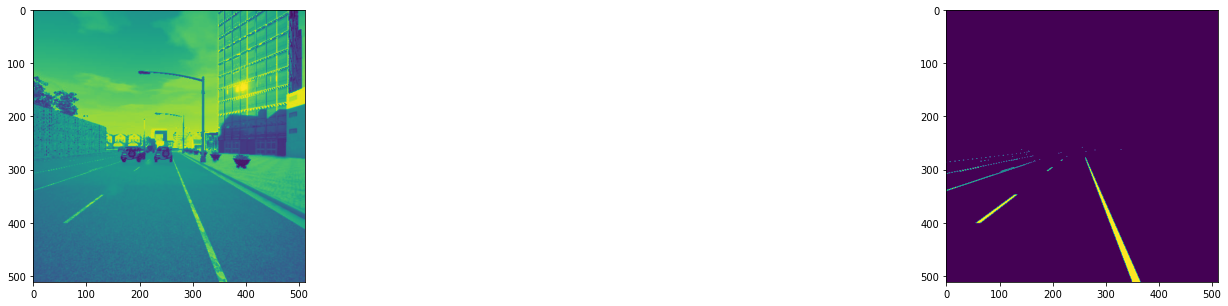

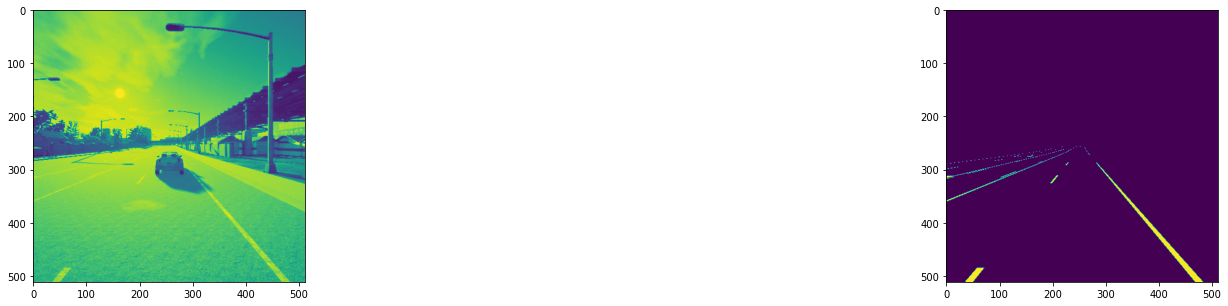

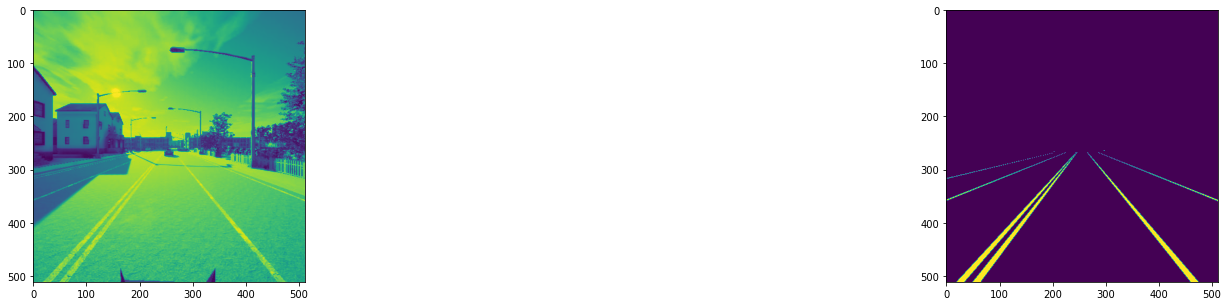

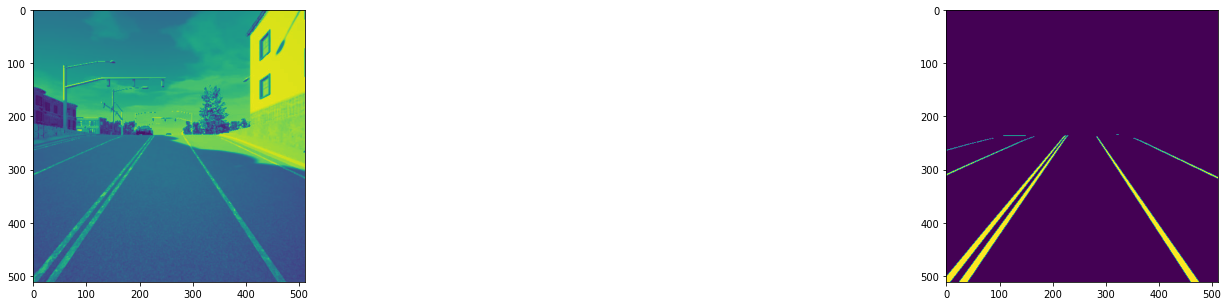

In [ ]:
plt.rcParams["figure.figsize"] = (30,5)

# Going through each image and segmentation
for image, segmentation in zip(image_batch, segmentation_batch):

  # Change the channel ordering
  image = np.moveaxis(image.numpy()*255, 0, -1)

  # Showing the image
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(image[:, :, 0])
  plt.subplot(1,2,2)
  plt.imshow(segmentation[6]*255)
  plt.show()

In [ ]:
segmentation.shape

torch.Size([25, 512, 512])

# Creating the Model

Here we will get setting up the model architecture, optimizer and loss.



In [ ]:
ENCODER = 'timm-efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = "softmax2d" 
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(train_dataset.labels),
    in_channels=1,
    activation=ACTIVATION,
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

# Hyperparameters & Metrics

In [ ]:
# using DiceLoss
loss = smp.utils.losses.DiceLoss()

# using multiple metrics to train the model
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
]

# Using Adam optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.006)

# Training the Model

In [ ]:
# Setting up training epoch to train the model
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# Training the model
train_logs = train_epoch.run(train_loader)

train: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it, dice_loss - 0.248, iou_score - 0.6329, fscore - 0.7622, accuracy - 0.9827, recall - 0.7504, precision - 0.7902]


# Generating Predictions

In [ ]:
# Creating the testing dataset

test_dataset = SemanticSegmentationDataset(img_directory="data/test/image", train=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2, shuffle=False, drop_last=False)

In [ ]:
# Generating Model Predictions
!rm -rf segmentation
!mkdir segmentation

for n, batch in enumerate(tqdm(test_loader)):

  # Getting the predictions
  predictions = model.predict(batch.to(DEVICE)).cpu() 
  
  # Converting the predictions to right format
  prediction_mask = (predictions.squeeze().cpu().numpy())   
  prediction_mask = np.transpose(prediction_mask, (1, 2, 0))

  # Getting individual channel and combining them into single image
  prediction_mask_gray = np.zeros((prediction_mask.shape[0],prediction_mask.shape[1]))
  for ii in range(prediction_mask.shape[2]):
    prediction_mask_gray = prediction_mask_gray + ii*prediction_mask[:,:,ii].round()


  # Saving the image
  prediction_mask_gray = Image.fromarray(prediction_mask_gray.astype(np.uint8))
  prediction_mask_gray.save(os.path.join("segmentation", f"{n}.png"))

  0%|          | 0/1000 [00:00<?, ?it/s]

# Submitting our Predictions
**Note : Please save the notebook before submitting it (Ctrl + S)**

In [ ]:
!aicrowd notebook submit -c scene-segmentation -a segmentation --no-verify

Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgVdnLp91l03I38HQ5VgmzkzARJ-HrMr0a332iRD88mbzH-neEGZ9M
Mounted at /content/drive
Using notebook: /content/drive/MyDrive/Colab Notebooks/Semantic Segmentation for submission...
Scrubbing API keys from the notebook..